In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),'..','..','..'))
from ursse.hydra_harp_file_reader import HydraHarpFile
from ursse.LED_tests.data_analyzis import calc_Fano, get_time_window_hist, calc_Fano_from_counts_per_time_window
import numpy as np
import pandas as pd
import seaborn as sns
from ursse.data_processing import \
    get_event_delays, plot_arrival_time_hist, get_events_array, get_fanos, \
    plot_fanos_hist, process_file, read_event_delays, save_event_delays
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 3.75]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import ursse.path_assistant as pa
shift = pa.PathAssistant('shift_02_28_2020')
from config_ursse import get_from_config
iota_period_sec = get_from_config("IOTA_revolution_period")
dt_sec = get_from_config("dt")
iota_period_au = iota_period_sec/dt_sec
import ursse_cpp.sync_motion_sim as sm

[source](http://cds.cern.ch/record/1038899/files/open-2007-018.pdf)

In [2]:
Cs = []
for i in range(4):
    with open(f"coeff{i+1}.txt") as f:
        data = [float(l) for l in f.readlines()]
        Cs.append(data)
C1, C2, C3, C4 = Cs
n1, n2, n3, n4 = [len(c)-1 for c in Cs]

In [3]:
def Cheb(a, b, C, n, x):
    y = (2*x-a-b)/(b-a)
    y2 = 2*y
    d = 0
    dd = 0
    j = n-1
    while j>=1:
        sv = d
        d = y2*d-dd+C[j]
        dd = sv
        j = j-1
    return y*d-dd+0.5*C[0]


x3 = 0.9132260271183847
x4 = 2.4444485538746025480
x5 = 9.3830728608909477079
x6 = 33.122936966163038145

    
def InvSynchFractInt(x):
    if x < 0.7:
        return x**3*Cheb(0,0.7,C1,n1,x)
    if x < x3:
        return Cheb(0.7,x3, C2, n2, x)
    if x < 1-0.0000841363:
        y = -np.log(1-x)
        return y*Cheb(x4, x5, C3, n3, y)
    if x <= 1:
        y = -np.log(1-x)
        return y*Cheb(x5, x6, C4, n4, y)
    else:
        return -1
InvSynchFractInt(0.999999999889)

20.004046963897608

In [4]:
c = 2.9979e10
gamma = 100/0.511
hbar_c = 0.1973269804e-4
rho = 70
Ec = 3/2*hbar_c*gamma**3/rho
Et = 88.9e-7*(gamma*0.511)**4/rho
Scale = 15*np.sqrt(3)/8*Et
alpha = 0.07088
V = 380
E0 = gamma*511000
f = 30e6
h = 4
v0 = V/E0
S = Scale/E0
eta = alpha - 1/gamma**2
w = 2*np.pi*h*eta

In [5]:
%%time
d_prev = 0
p_prev = 0
deltas = []
phis = []
nper = 1000000
for i in range(nper):
    deltas.append(d_prev)
    phis.append(p_prev)
    e = InvSynchFractInt(np.random.rand())*Scale
    d = d_prev + v0*np.sin(p_prev) - e/E0
    p = p_prev - w*d
    d_prev = d
    p_prev = p
deltas = np.array(deltas)
phis = np.array(phis)
taus = phis*1e9/2/np.pi/f

CPU times: user 7.51 s, sys: 19.4 ms, total: 7.52 s
Wall time: 7.52 s


In [6]:
%%time
sim_df = sm.get_trajectory(gamma, alpha, V, f, nper, 0, 0, 1)

CPU times: user 252 ms, sys: 54 µs, total: 252 ms
Wall time: 249 ms


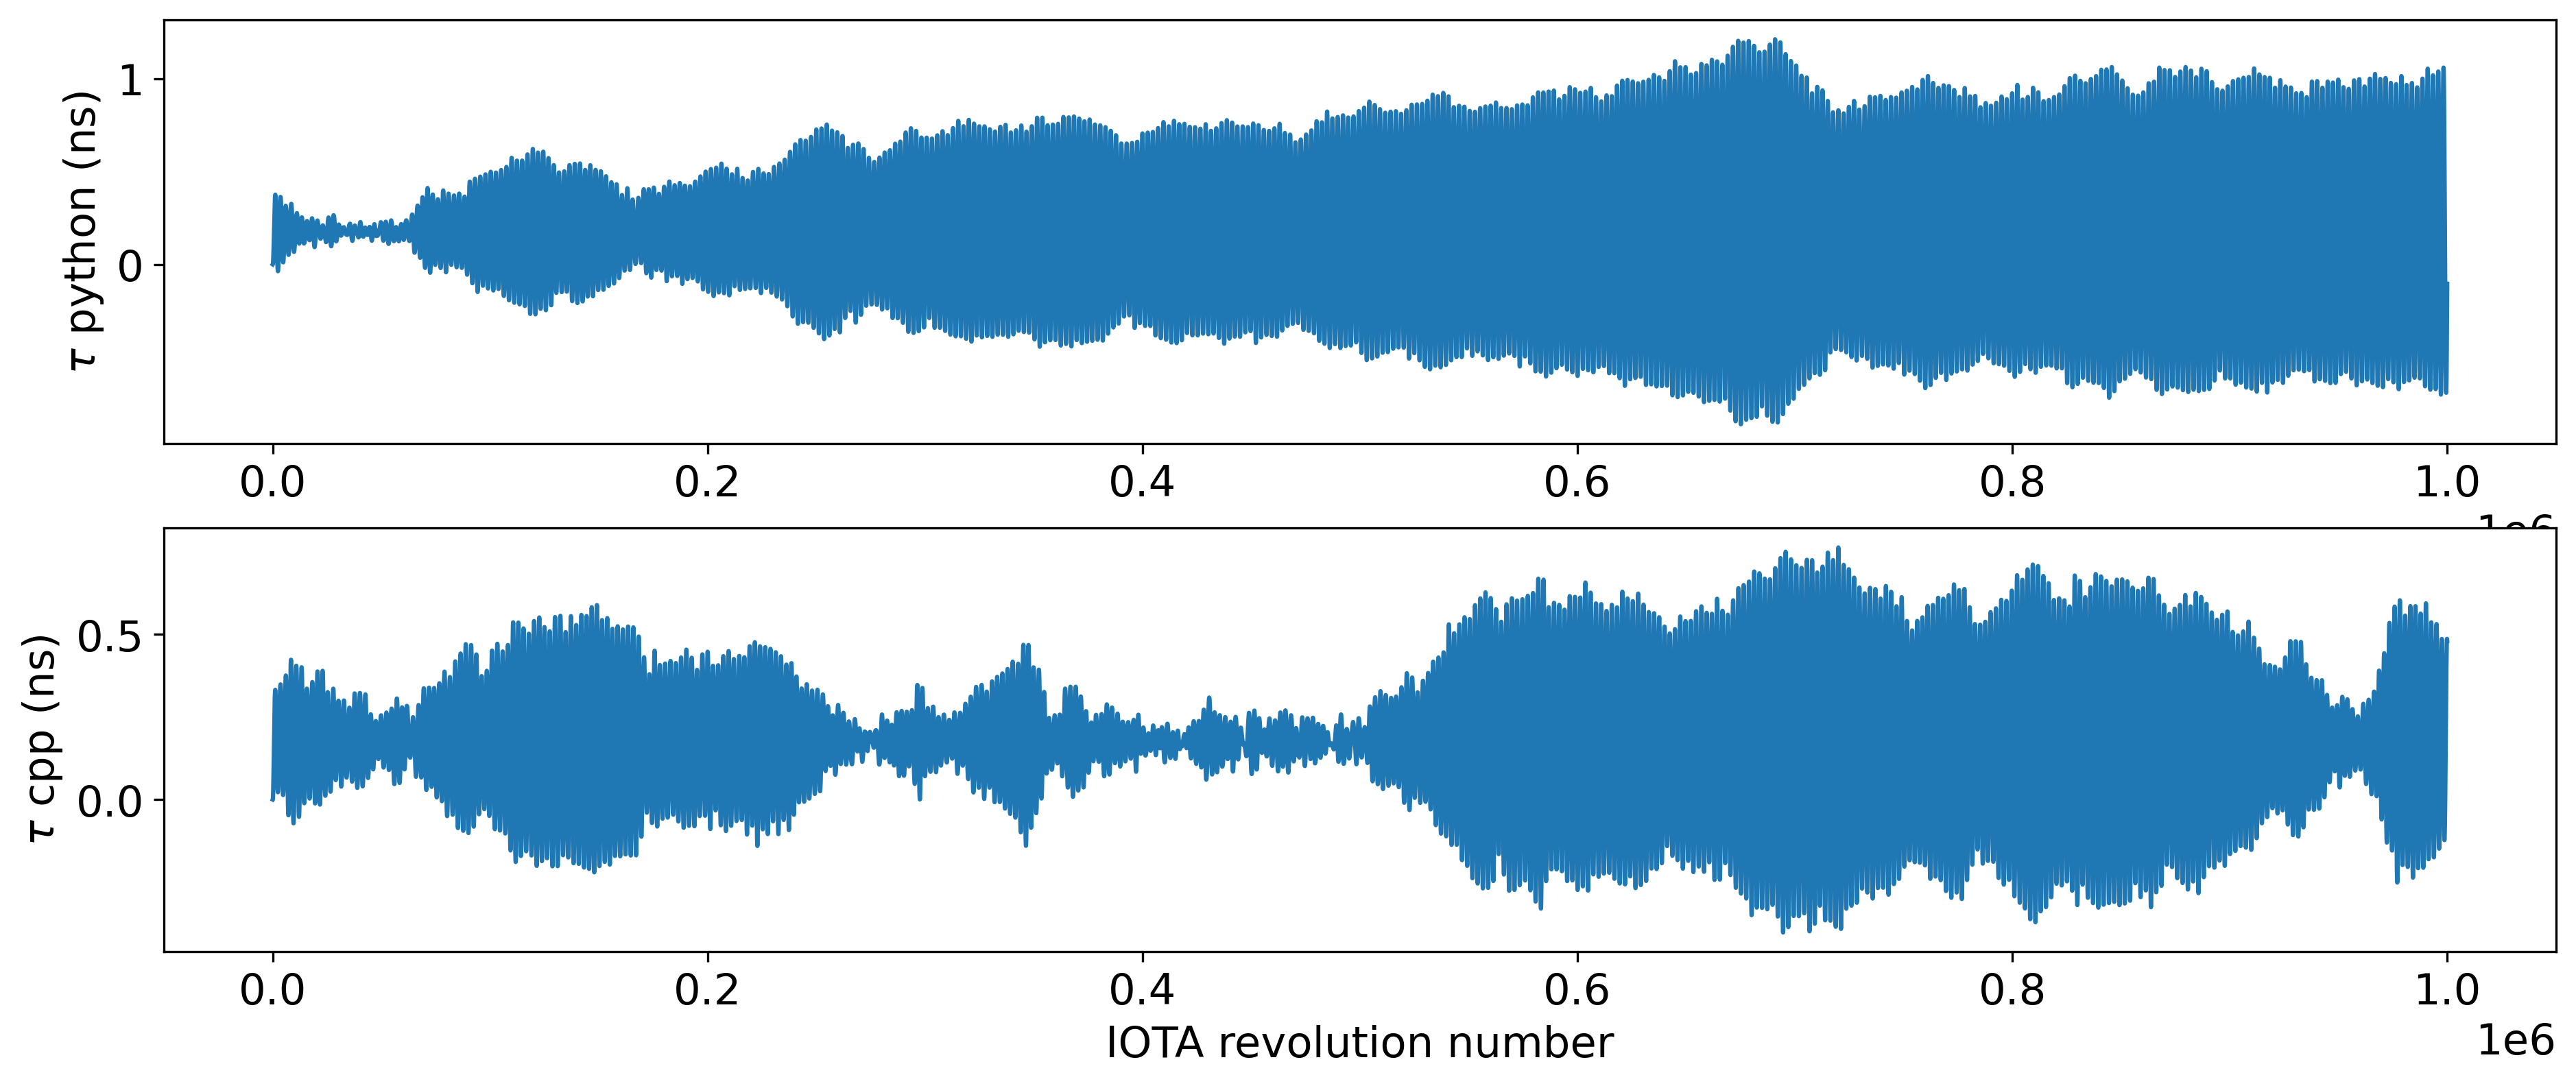

In [9]:
plt.rcParams.update({'font.size': 15,
                     'legend.fontsize':22,
                     'errorbar.capsize': 3,
                     'figure.figsize':(15,6),
                     'figure.dpi':300})
fig, ax = plt.subplots(2)
ax[0].plot(taus)
ax[0].set_ylabel(r'$\tau$ python (ns)')
ax[1].set_xlabel("IOTA revolution number")
ax[1].plot(sim_df["tau_ns"])
ax[1].set_ylabel(r'$\tau$ cpp (ns)')
# ax1 = ax.twiny()
# ax1.set_xlim(1000*iota_period_sec*np.asarray(ax.get_xlim()))
# ax1.set_xlabel('Time (ms)')
fig.show()